![](demo.png)

# Classification of Apparel Fit Using CNN's
___

## Dataset
The dataset consists of 520 fashion images of men's tops. They have been given one of four labels regarding the fit of the clothing:

* Tight Fitting
* Slim Fit 
* Relaxed Fit 
* Oversized

All images were obtained from ecommerce websites or image searches and are in no way the property of the researcher. 

___
### Directory Map
- fit_images
    - train
        - oversized
        - relaxed
        - slim 
        - tight
    - valid
        - oversized
        - relaxed
        - slim 
        - tight
    - test
        - oversized
        - relaxed
        - slim 
        - tight

___

In [1]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import time
import glob
from vis.visualization import visualize_cam
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from vis.input_modifiers import Jitter
from keras import activations
from scipy import misc, ndimage
import imageio
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\Users\Loren\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
#folders = os.listdir()[1:-1]

In [25]:
# Function to rename multiple files 
#n = 0
#for dirname in os.listdir("."):
#    if os.path.isdir(dirname):
#        for i, filename in enumerate(os.listdir(dirname)):
#            os.rename(dirname + "/" + filename, dirname + "/fit_photo" + str(n) + ".jpg")
#            n+=1

# Data Exploration
The data has been divided evenly by category. For each category there are 100 train images, 20 validation images and 10 test images.  

### Below are some examples of the different categories.

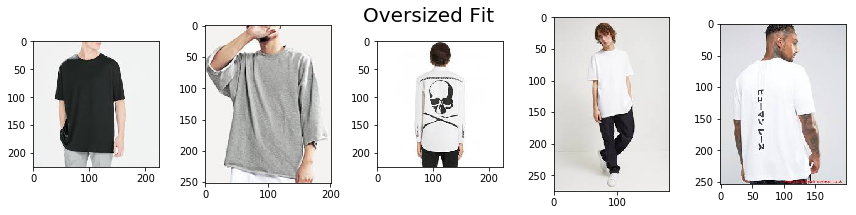

In [38]:
f, ax = plt.subplots(nrows=1,ncols=5, figsize=(12,3))

for i in range(0,5): 
    file = glob.glob("train/oversized/*.jpg")[i]
    ax[i].imshow(imageio.imread(file))
    

plt.suptitle("Oversized Fit", fontsize=20)
plt.tight_layout()
plt.show()

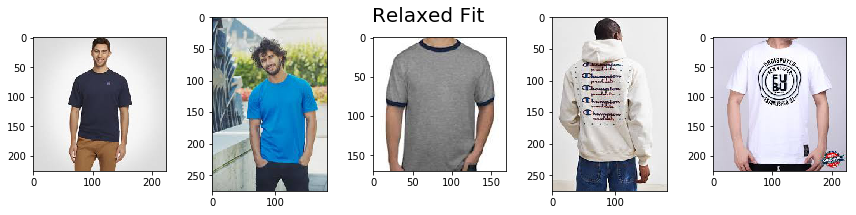

In [39]:
f, ax = plt.subplots(nrows=1,ncols=5, figsize=(12,3))

for i in range(0,5): 
    file = glob.glob("train/relaxed/*.jpg")[i]
    ax[i].imshow(imageio.imread(file))
    

plt.suptitle("Relaxed Fit", fontsize=20)
plt.tight_layout()
plt.show()

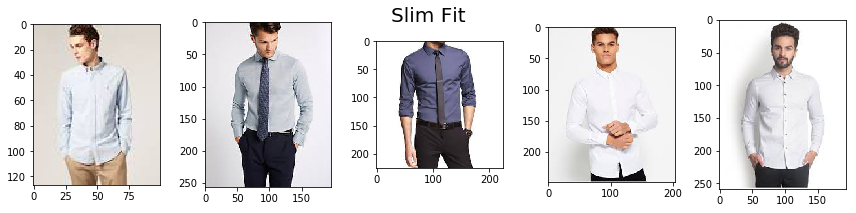

In [40]:
f, ax = plt.subplots(nrows=1,ncols=5, figsize=(12,3))

for i in range(0,5): 
    file = glob.glob("train/slim/*.jpg")[i]
    ax[i].imshow(imageio.imread(file))
    

plt.suptitle("Slim Fit", fontsize=20)
plt.tight_layout()
plt.show()

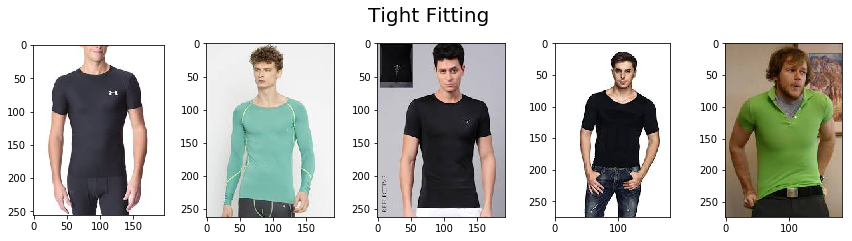

In [44]:
f, ax = plt.subplots(nrows=1,ncols=5, figsize=(12,3))

for i in range(0,5): 
    file = glob.glob("train/tight/*.jpg")[i]
    ax[i].imshow(imageio.imread(file))
    

plt.suptitle("Tight Fitting", fontsize=20, y=1.10)
plt.tight_layout()
plt.show()

In [2]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

# Data Augmentation

As there are only 100 training images for each class, data augmentation will be used to increase the amount of training data. 


In [3]:
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)

train_batches = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(224, 224),  # all images will be resized 
        batch_size=10,
        shuffle=True,
        class_mode='categorical')


valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), batch_size=10, shuffle=True, class_mode='categorical')


Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [44]:
imgs, labels = next(train_batches)

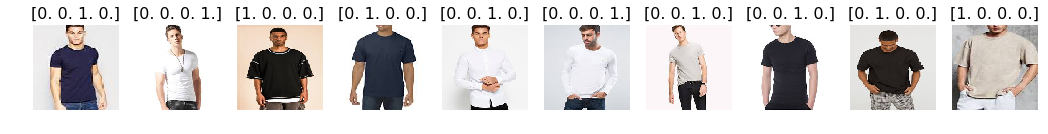

In [45]:
plots(imgs, titles=labels)

## Example Image 

Here is an example of a training image and below are the augmentations that will be made.

In [4]:
image_path = 'train/oversized/fit_photo79.jpg'

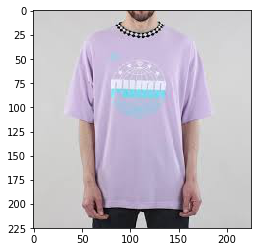

In [5]:
# Obtain image
test_image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(test_image[0])
plt.show()

In [6]:
# Generate batches of augmented images from this image
aug_iter = train_datagen.flow(test_image)

In [7]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(18,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

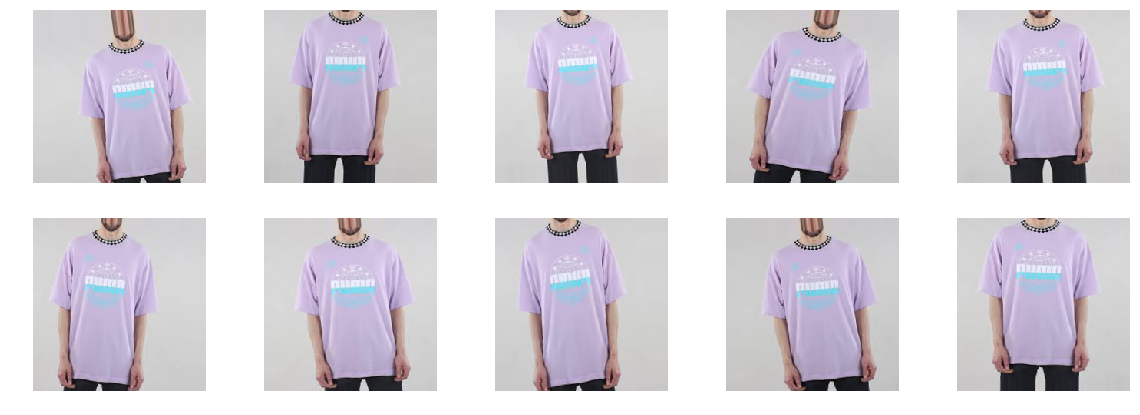

In [9]:
# Augmented images
plots(aug_images, figsize=(20,7), rows=2)

# Model Architecture 

Training a deep CNN from scratch with a small dataset is not feasible, so we'll use transfer learning to utilize the high level features of a pre-trained model.

The model we'll use is the VGG-16. This model was used to win the ILSVR (ImageNet) competition in 2014. 

In order to utilize the features of the VGG-16, the first 22 layers will be frozen, and only the weights of the last layer will be updated in training. 

### Here is a summary of the VGG-16 model

In [4]:
vgg16_model = keras.applications.vgg16.VGG16()

In [5]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### The VGG-16 was trained to classify the 1000 different classes of the ImageNet dataset. In order to train the model to classify the fit of fashion images, the last dense layer will be removed and replaced with  a dense layer that has 4 output nurons. 

In [6]:
type(vgg16_model)

keras.engine.training.Model

In [7]:
# The VGG-16 is a model object. In order to replace the last layer it will need to be turned into a sequential model.
lay = 0
model = Sequential()
 
for layer in vgg16_model.layers:
    if lay < 22:
        model.add(layer)
        lay+=1

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [9]:
for layer in model.layers:
    layer.trainable = False

In [10]:
model.add(Dense(4, activation='softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [12]:
#model.get_config()
model.layers[-1].get_config()
#model.layers[0].input_shape
#model.layers[0].output_shape
#model.layers[0].get_weights()
#np.shape(model.layers[0].get_weights()[0])
#model.layers[0].trainable

{'name': 'dense_1',
 'trainable': True,
 'units': 4,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [13]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training 

In [14]:
# Callback functions
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir="logs", write_graph=True, write_images=True)
early_stopper = EarlyStopping(monitor='val_loss',
                              mode='auto')
checkpoint = ModelCheckpoint('./models/model.h5')

In [15]:
training = model.fit_generator(train_batches, 
                        steps_per_epoch=40, 
                        validation_data=valid_batches, 
                        validation_steps=8, 
                        epochs=25, verbose=2, 
                        callbacks=[lr_reducer, tensorboard])

Epoch 1/25
 - 407s - loss: 2.0205 - acc: 0.2500 - val_loss: 1.7283 - val_acc: 0.3250
Epoch 2/25
 - 404s - loss: 1.3505 - acc: 0.4450 - val_loss: 1.3594 - val_acc: 0.4250
Epoch 3/25
 - 423s - loss: 1.1047 - acc: 0.5200 - val_loss: 1.1746 - val_acc: 0.5250
Epoch 4/25
 - 409s - loss: 0.9980 - acc: 0.5675 - val_loss: 1.0638 - val_acc: 0.5875
Epoch 5/25
 - 431s - loss: 0.9192 - acc: 0.5850 - val_loss: 0.9595 - val_acc: 0.5750
Epoch 6/25
 - 408s - loss: 0.8203 - acc: 0.6525 - val_loss: 0.9154 - val_acc: 0.6000
Epoch 7/25
 - 407s - loss: 0.7835 - acc: 0.6675 - val_loss: 0.8614 - val_acc: 0.6750
Epoch 8/25
 - 414s - loss: 0.7436 - acc: 0.7000 - val_loss: 0.8193 - val_acc: 0.6750
Epoch 9/25
 - 415s - loss: 0.6932 - acc: 0.7175 - val_loss: 0.8242 - val_acc: 0.6250
Epoch 10/25
 - 411s - loss: 0.6374 - acc: 0.7300 - val_loss: 0.7814 - val_acc: 0.6500
Epoch 11/25
 - 411s - loss: 0.6355 - acc: 0.7350 - val_loss: 0.8031 - val_acc: 0.6875
Epoch 12/25
 - 416s - loss: 0.5792 - acc: 0.7350 - val_loss: 0.

In [16]:
import json
from keras.models import model_from_json, load_model


#Save Weights + Architecture
model.save_weights('model_weights2.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [12]:
model.load_weights('model_weights2.h5')

# Model Evaluation

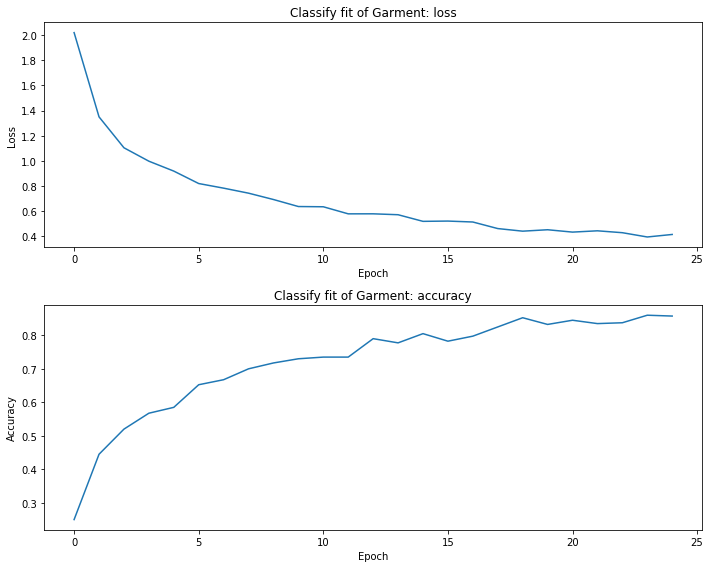

In [18]:
## Trained model analysis and evaluation
f, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(training.history['loss'])
ax[0].set_title('Classify fit of Garment: loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Accuracy
ax[1].plot(training.history['acc'])
ax[1].set_title('Classify fit of Garment: accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [20]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 40 images belonging to 4 classes.


In [31]:
predictions = model.predict_generator(test_batches, steps=4, verbose=0)

In [32]:
test_labels = test_batches.classes
np.round(test_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

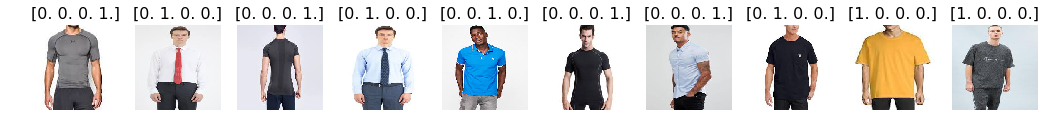

In [66]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [25]:
model.metrics_names

['loss', 'acc']

In [26]:
score = model.evaluate_generator(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8655730560421944
Test accuracy: 0.75


######  Test loss: 0.8655730560421944 
######  Test accuracy: 0.75  


  
  
#### Let's take a look at a confusion matrix of the 40 sample test set

In [33]:
predicted_class_indices=np.argmax(predictions,axis=1)

In [28]:
predicted_class_indices

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2, 2, 2,
       3, 2, 2, 2, 1, 2, 1, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [34]:
labels = (test_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction_labels = [labels[k] for k in predicted_class_indices]

In [35]:
cm = confusion_matrix(np.round(test_labels), predicted_class_indices)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize=(8,8),
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  0  0  0]
 [ 0  5  3  2]
 [ 1  1  7  1]
 [ 0  0  2  8]]


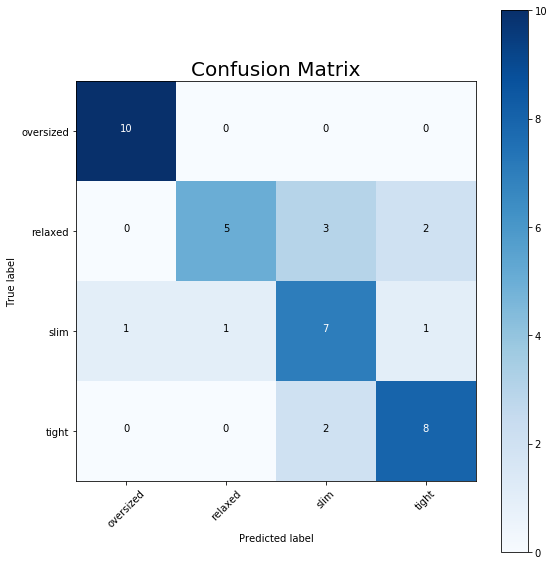

In [37]:
cm_plot_labels = ['oversized','relaxed', 'slim', 'tight']
plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')